In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster

import matplotlib.pyplot as plt
import cartopy
import cmocean
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils

import metpy.calc as mpcalc

#### Define case and path

In [2]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

In [3]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

#### Get grid

In [4]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

#### Define variable list

In [5]:
variables = ['diatC','NO3','HMXL','Fe','TEMP','HMXL_DR']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [6]:
def preprocess(ds):
    ds=ds.isel(z_t=slice(0,17))
    return ds

In [9]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.199901-199912.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

starting on  diatC
starting on  NO3
starting on  HMXL
starting on  Fe
starting on  TEMP
starting on  HMXL_DR


In [10]:
ds_fosi_x01["time"] = ds_fosi_x01.time_bound.compute().mean(dim="d2")

In [37]:
ds_fosi_x01

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 2400, nlon: 3600, time: 12, z_t: 17, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 1.55e+04 1.651e+04
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
  * time        (time) object 1999-01-16 12:00:00 ... 1999-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    dz          (z_t) float32 dask.array<chunksize=(17,), meta=np.ndarray>
    time_bound  (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    diatC       (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(12, 15, 2400, 3600), meta=np.ndarray>
    NO3         (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 17, 2400, 3600), meta=np.ndarray>
    HMXL        (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    Fe          (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 17, 2400, 3600), meta=np.ndarray>
    TEMP        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 17, 2400, 3600), meta=np.ndarray>
    HMXL_DR     (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>

### Now grab year for eq Pac timeslice (Sept 1960)

In [12]:
ds_fosi_x01_2 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.196001-196012.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01_2 = xr.merge([ds_fosi_x01_2,ds_tmp])

starting on  diatC
starting on  NO3
starting on  HMXL
starting on  Fe
starting on  TEMP
starting on  HMXL_DR


In [13]:
ds_fosi_x01_2["time"] = ds_fosi_x01_2.time_bound.compute().mean(dim="d2")

### Now find at what latitude index we need to make transects

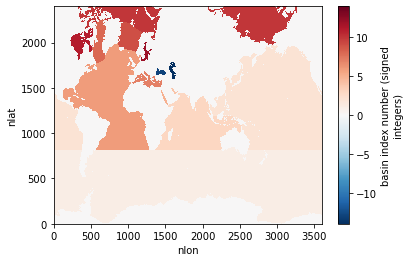

In [14]:
ds_grid.REGION_MASK.plot()

In [15]:
ds_grid.TLAT.isel(nlat=1636).values ### Cross section through CA current at 39N

array([39.04835473, 39.0483857 , 39.04844762, ..., 39.04844762,
       39.0483857 , 39.04835473])

In [16]:
ds_grid.TLAT.isel(nlat=1500).values ### Cross section through SE US shelf current at 39N

array([30.00615491, 30.00615932, 30.00616816, ..., 30.00616816,
       30.00615932, 30.00615491])

In [17]:
ds_grid.TLAT.isel(nlat=1202).values ### Cross section through Eq. Pac at 2N


array([2.04959423, 2.04959423, 2.04959423, ..., 2.04959423, 2.04959423,
       2.04959423])

### grab months for plots and make the trasect

In [18]:
ds_CAcurr = ds_fosi_x01.isel(time=2,nlat=1636)

In [19]:
ds_SEUS = ds_fosi_x01.isel(time=2,nlat=1500)

In [20]:
ds_eqPac = ds_fosi_x01_2.isel(time=8,nlat=1202)

### Figure out which longitudinal extents to show in the figure

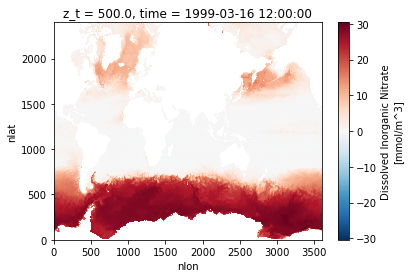

In [21]:
ds_fosi_x01.NO3.isel(time=2,z_t=0).plot()

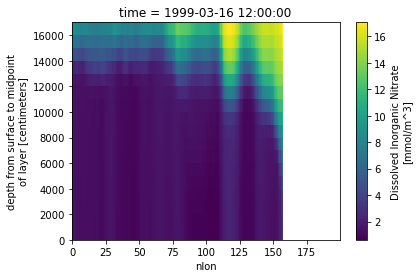

In [22]:
ds_CAcurr.NO3.isel(nlon=slice(3300,3500)).plot()

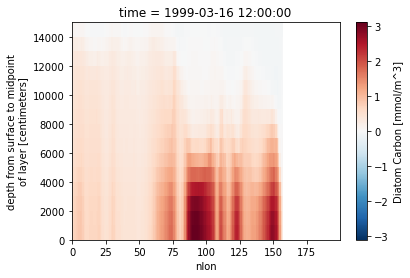

In [23]:
ds_CAcurr.diatC.isel(nlon=slice(3300,3500)).plot()

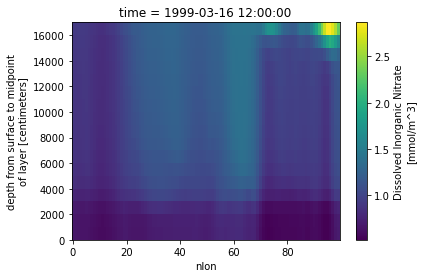

In [24]:
ds_SEUS.NO3.isel(nlon=slice(400,500)).plot()

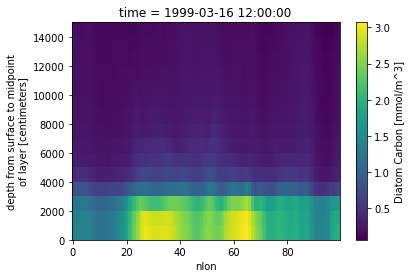

In [25]:
ds_SEUS.diatC.isel(nlon=slice(400,500)).plot()

In [26]:
#ds_eqPac.TLONG.isel(nlon=slice(2900,3600)).values


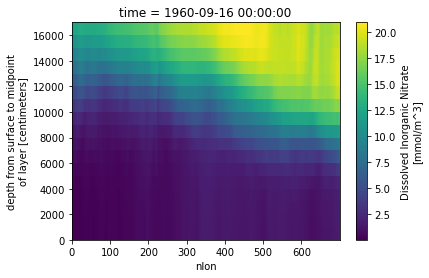

In [27]:
ds_eqPac.NO3.isel(nlon=slice(2900,3600)).plot()

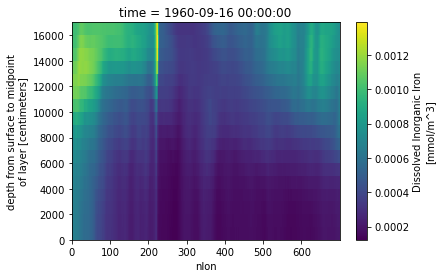

In [28]:
ds_eqPac.Fe.isel(nlon=slice(2900,3600)).plot()

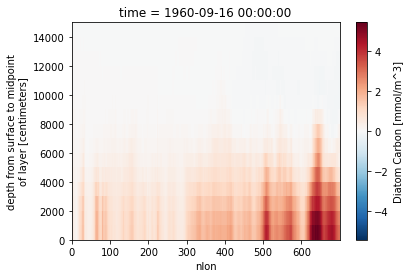

In [29]:
ds_eqPac.diatC.isel(nlon=slice(2900,3600)).plot()

In [36]:
depths = (ds_fosi_x01.z_t[0:18] /100).values
depths

array([  5.    ,  15.    ,  25.    ,  35.    ,  45.    ,  55.    ,
        65.    ,  75.    ,  85.    ,  95.    , 105.    , 115.    ,
       125.    , 135.    , 145.    , 155.    , 165.0984], dtype=float32)

In [38]:
tmp

<xarray.DataArray 'diatC' (z_t_150m: 15, nlon: 700)>
dask.array<getitem, shape=(15, 700), dtype=float32, chunksize=(15, 700), chunktype=numpy.ndarray>
Coordinates:
  * z_t_150m  (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLONG     (nlon) float64 dask.array<chunksize=(700,), meta=np.ndarray>
    TLAT      (nlon) float64 dask.array<chunksize=(700,), meta=np.ndarray>
    time      object 1960-09-16 00:00:00
Dimensions without coordinates: nlon
Attributes:
    long_name:     Diatom Carbon
    units:         mmol/m^3
    grid_loc:      3114
    cell_methods:  time: mean

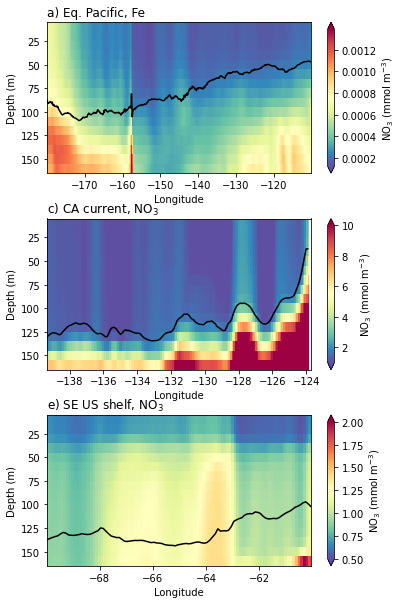

In [40]:
fig = plt.figure(figsize=(13,10))

############# Eq Pac

### NO3
var = 'NO3'
cmap='Spectral_r'
ax = fig.add_subplot(3,2,1)
ax.set_title('a) Eq. Pacific, Fe',fontsize=12, loc='left')
#tmp = ds_eqPac.NO3.isel(nlon=slice(2900,3600)) * 1000 
tmp = ds_eqPac.Fe.isel(nlon=slice(2900,3600)) 
lon = lons_norm.isel(nlon=slice(2900,3600),nlat=1202)
mld = ds_eqPac.HMXL.isel(nlon=slice(2900,3600)) * 0.01
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap) #, vmin=0.15,vmax=0.6)
#pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=0.15,vmax=0.6)
ml = ax.plot(lon,mld,color='black')
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');
#fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');
########### diatC
# var = 'NO3'
# cmap='RdYlGn'
# ax = fig.add_subplot(3,2,2)
# ax.set_title('b) Eq. Pacific, diatom carbon',fontsize=12, loc='left')
# tmp = ds_eqPac.diatC.isel(nlon=slice(2900,3600))
# lon = lons_norm.isel(nlon=slice(2900,3600),nlat=1202)
# pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap)
# plt.gca().invert_yaxis()
# mld = ds_eqPac.HMXL.isel(nlon=slice(2900,3600)) * 0.01
# ml = ax.plot(lon,mld,color='black')
# ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
# fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

############################### Ca CUrrent

### NO3
var = 'NO3'
cmap='Spectral_r'
ax = fig.add_subplot(3,2,3)
ax.set_title('c) CA current, NO$_3$',fontsize=12, loc='left')
tmp = ds_CAcurr.NO3.isel(nlon=slice(3300,3460))
lon = lons_norm.isel(nlon=slice(3300,3460),nlat=1636)
mld = ds_CAcurr.HMXL.isel(nlon=slice(3300,3460)) * 0.01
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=1,vmax=10)
ml = ax.plot(lon,mld,color='black')
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

########### diatC
# var = 'NO3'
# cmap='Greens'
# ax = fig.add_subplot(3,2,4)
# ax.set_title('d) CA current, diatom carbon',fontsize=12, loc='left')
# tmp = ds_CAcurr.diatC.isel(nlon=slice(3300,3460))
# lon = lons_norm.isel(nlon=slice(3300,3460),nlat=1636)
# pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap)
# plt.gca().invert_yaxis()
# mld = ds_CAcurr.HMXL.isel(nlon=slice(3300,3460)) * 0.01
# ml = ax.plot(lon,mld,color='black')
# ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
# fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

############################### SE US shelf

### NO3
var = 'NO3'
cmap='Spectral_r'
ax = fig.add_subplot(3,2,5)
ax.set_title('e) SE US shelf, NO$_3$',fontsize=12, loc='left')
tmp = ds_SEUS.NO3.isel(nlon=slice(400,500))
lon = lons_norm.isel(nlon=slice(400,500),nlat=1500)
mld = ds_SEUS.HMXL.isel(nlon=slice(400,500)) * 0.01
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=0.5,vmax=2)
ml = ax.plot(lon,mld,color='black')
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

########### diatC
# var = 'NO3'
# cmap='Greens'
# ax = fig.add_subplot(3,2,6)
# ax.set_title('f) SE US shelf, diatom carbon',fontsize=12, loc='left')
# tmp = ds_SEUS.diatC.isel(nlon=slice(400,500))
# lon = lons_norm.isel(nlon=slice(400,500),nlat=1500)
# pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap)
# plt.gca().invert_yaxis()
# mld = ds_SEUS.HMXL.isel(nlon=slice(400,500)) * 0.01
# ml = ax.plot(lon,mld,color='black')
# ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
# fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

fig.subplots_adjust(hspace=0.3)

In [ ]:
depths

In [ ]:
depths[0:8]

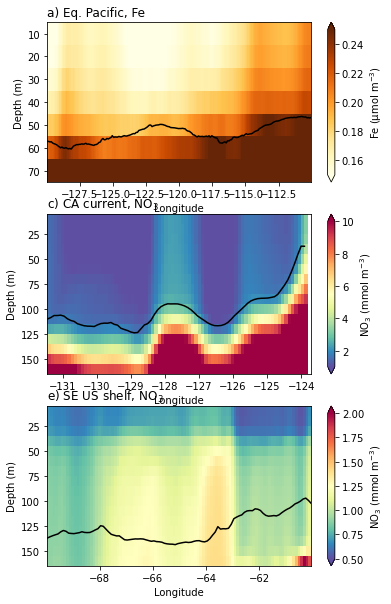

In [41]:
fig = plt.figure(figsize=(13,10))

############# Eq Pac

### NO3

cmap='YlOrBr'
ax = fig.add_subplot(3,2,1)
ax.set_title('a) Eq. Pacific, Fe',fontsize=12, loc='left')
#tmp = ds_eqPac.NO3.isel(nlon=slice(2900,3600))
tmp = ds_eqPac.Fe.isel(nlon=slice(3400,3600),z_t=slice(0,8))  * 1000 
lon = lons_norm.isel(nlon=slice(3400,3600),nlat=1202)
mld = ds_eqPac.HMXL.isel(nlon=slice(3400,3600)) * 0.01
pc = ax.pcolormesh(lon,depths[0:8],tmp, cmap=cmap, vmin=0.15,vmax=0.25)
#pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=0.15,vmax=0.6)
ml = ax.plot(lon,mld,color='black')
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
#fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');
########### diatC

# cmap='Greens'
# ax = fig.add_subplot(3,2,2)
# ax.set_title('b) Eq. Pacific, diatom carbon',fontsize=12, loc='left')
# tmp = ds_eqPac.diatC.isel(nlon=slice(3400,3600),z_t_150m=slice(0,8))
# lon = lons_norm.isel(nlon=slice(3400,3600),nlat=1202)
# pc = ax.pcolormesh(lon,depths[0:8],tmp, cmap=cmap)
# plt.gca().invert_yaxis()
# mld = ds_eqPac.HMXL.isel(nlon=slice(3400,3600)) * 0.01
# ml = ax.plot(lon,mld,color='black')
# ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
# fig.colorbar(pc, label='Diatom C (mmol m$^{-3}$)',extend='both');

# ############################### Ca CUrrent

### NO3
var = 'NO3'
cmap='Spectral_r'
ax = fig.add_subplot(3,2,3)
ax.set_title('c) CA current, NO$_3$',fontsize=12, loc='left')
tmp = ds_CAcurr.NO3.isel(nlon=slice(3380,3460))
lon = lons_norm.isel(nlon=slice(3380,3460),nlat=1636)
mld = ds_CAcurr.HMXL.isel(nlon=slice(3380,3460)) * 0.01
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=1,vmax=10)
ml = ax.plot(lon,mld,color='black')
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

# ########### diatC
# var = 'NO3'
# cmap='Greens'
# ax = fig.add_subplot(3,2,4)
# ax.set_title('d) CA current, diatom carbon',fontsize=12, loc='left')
# tmp = ds_CAcurr.diatC.isel(nlon=slice(3380,3460))
# lon = lons_norm.isel(nlon=slice(3380,3460),nlat=1636)
# pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap)
# plt.gca().invert_yaxis()
# mld = ds_CAcurr.HMXL.isel(nlon=slice(3380,3460)) * 0.01
# ml = ax.plot(lon,mld,color='black')
# ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
# fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

############################### SE US shelf

### NO3
var = 'NO3'
cmap='Spectral_r'
ax = fig.add_subplot(3,2,5)
ax.set_title('e) SE US shelf, NO$_3$',fontsize=12, loc='left')
tmp = ds_SEUS.NO3.isel(nlon=slice(400,500))
lon = lons_norm.isel(nlon=slice(400,500),nlat=1500)
mld = ds_SEUS.HMXL.isel(nlon=slice(400,500)) * 0.01
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=0.5,vmax=2)
ml = ax.plot(lon,mld,color='black')
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

# ########### diatC
# var = 'NO3'
# cmap='Greens'
# ax = fig.add_subplot(3,2,6)
# ax.set_title('f) SE US shelf, diatom carbon',fontsize=12, loc='left')
# tmp = ds_SEUS.diatC.isel(nlon=slice(400,500))
# lon = lons_norm.isel(nlon=slice(400,500),nlat=1500)
# pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap)
# plt.gca().invert_yaxis()
# mld = ds_SEUS.HMXL.isel(nlon=slice(400,500)) * 0.01
# ml = ax.plot(lon,mld,color='black')
# ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
# fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

# fig.subplots_adjust(hspace=0.3)

#### Nuts, TEMP, and MLD

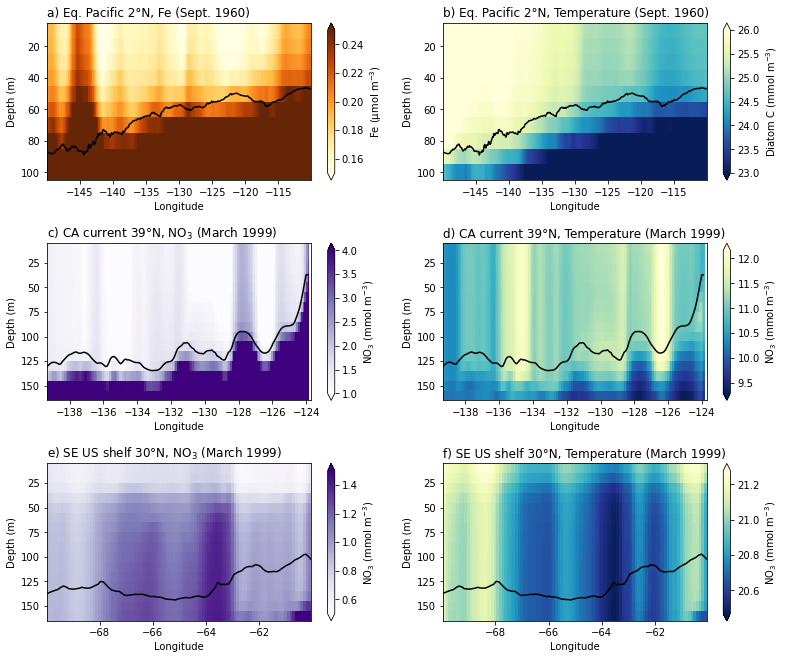

In [84]:
fig = plt.figure(figsize=(13,11))

############# Eq Pac

cmap='YlOrBr'
ax = fig.add_subplot(3,2,1)
ax.set_title('a) Eq. Pacific 2°N, Fe (Sept. 1960)',fontsize=12, loc='left')
#tmp = ds_eqPac.NO3.isel(nlon=slice(2900,3600))
tmp = ds_eqPac.Fe.isel(nlon=slice(3200,3600),z_t=slice(0,11))  * 1000 
lon = lons_norm.isel(nlon=slice(3200,3600),nlat=1202)
mld = ds_eqPac.HMXL.isel(nlon=slice(3200,3600)) * 0.01
pc = ax.pcolormesh(lon,depths[0:11],tmp, cmap=cmap, vmin=0.15,vmax=0.25)
#pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=0.15,vmax=0.6)
ml = ax.plot(lon,mld,color='black')
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
#fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');


########### TEMP
cmap='YlGnBu_r'
ax = fig.add_subplot(3,2,2)
ax.set_title('b) Eq. Pacific 2°N, Temperature (Sept. 1960)',fontsize=12, loc='left')
tmp = ds_eqPac.TEMP.isel(nlon=slice(3200,3600),z_t=slice(0,11))
lon = lons_norm.isel(nlon=slice(3200,3600),nlat=1202)
pc = ax.pcolormesh(lon,depths[0:11],tmp, cmap=cmap, vmin=23, vmax=26)
plt.gca().invert_yaxis()
mld = ds_eqPac.HMXL.isel(nlon=slice(3200,3600)) * 0.01
ml = ax.plot(lon,mld,color='black')
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Diatom C (mmol m$^{-3}$)',extend='both');

############################### Ca CUrrent

### NO3
var = 'NO3'
cmap='Purples'
ax = fig.add_subplot(3,2,3)
ax.set_title('c) CA current 39°N, NO$_3$ (March 1999)',fontsize=12, loc='left')
tmp = ds_CAcurr.NO3.isel(nlon=slice(3300,3460))
lon = lons_norm.isel(nlon=slice(3300,3460),nlat=1636)
mld = ds_CAcurr.HMXL.isel(nlon=slice(3300,3460)) * 0.01
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=1,vmax=4)
ml = ax.plot(lon,mld,color='black')
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

########### TEMP
cmap='YlGnBu_r'
ax = fig.add_subplot(3,2,4)
ax.set_title('d) CA current 39°N, Temperature (March 1999)',fontsize=12, loc='left')
tmp = ds_CAcurr.TEMP.isel(nlon=slice(3300,3460))
lon = lons_norm.isel(nlon=slice(3300,3460),nlat=1636)
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap)
plt.gca().invert_yaxis()
mld = ds_CAcurr.HMXL.isel(nlon=slice(3300,3460)) * 0.01
ml = ax.plot(lon,mld,color='black')
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

############################### SE US shelf

### NO3
cmap='Purples'
ax = fig.add_subplot(3,2,5)
ax.set_title('e) SE US shelf 30°N, NO$_3$ (March 1999)',fontsize=12, loc='left')
tmp = ds_SEUS.NO3.isel(nlon=slice(400,500))
lon = lons_norm.isel(nlon=slice(400,500),nlat=1500)
mld = ds_SEUS.HMXL.isel(nlon=slice(400,500)) * 0.01
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=0.5,vmax=1.5)
ml = ax.plot(lon,mld,color='black')
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

########### TEMP
var = 'NO3'
cmap='YlGnBu_r'
ax = fig.add_subplot(3,2,6)
ax.set_title('f) SE US shelf 30°N, Temperature (March 1999)',fontsize=12, loc='left')
tmp = ds_SEUS.TEMP.isel(nlon=slice(400,500))
lon = lons_norm.isel(nlon=slice(400,500),nlat=1500)
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap)
plt.gca().invert_yaxis()
mld = ds_SEUS.HMXL.isel(nlon=slice(400,500)) * 0.01
ml = ax.plot(lon,mld,color='black')
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

fig.subplots_adjust(hspace=0.4)

fig.savefig('/glade/work/kristenk/figs/Regional_transects_x01.png', bbox_inches='tight', dpi=300, format='png');

In [43]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/' + case + '/ocn/proc/tseries/month_1/'

In [44]:
ds_fosi = xr.Dataset()
#ds_fosi_seas = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    ds_tmp = xr.open_dataset(path + case + '.pop.h.' + var + '.195801-202112.nc')
    
    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    ds_fosi = xr.merge([ds_fosi,ds_tmp],combine_attrs='override')

starting on  diatC
starting on  NO3
starting on  HMXL
starting on  Fe
starting on  TEMP
starting on  HMXL_DR


In [45]:
ds_fosi

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 768, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... nan nan nan nan
  * time        (time) object 1958-02-01 00:00:00 ... 2022-01-01 00:00:00
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    diatC       (time, z_t_150m, nlat, nlon) float32 ...
    dz          (z_t) float32 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    time_bound  (time, d2) object 1958-01-01 02:00:00.000003 ... 2022-01-01 0...
    NO3         (time, z_t, nlat, nlon) float32 ...
    HMXL        (time, nlat, nlon) float32 ...
    Fe          (time, z_t, nlat, nlon) float32 ...
    TEMP        (time, z_t, nlat, nlon) float32 ...
    HMXL_DR     (time, nlat, nlon) float32 ...

In [46]:
ds_fosi["time"] = ds_fosi.time_bound.compute().mean(dim="d2")

### Find closest lats cross sections in x1

In [47]:
ds_grid_x1 = pop_tools.get_grid('POP_gx1v7')
lats_x1 = ds_grid_x1.TLAT
lons_x1 = ds_grid_x1.TLONG
area_x1 = ds_grid_x1.TAREA
lons_norm_x1 = utils.normal_lons(lons_x1)

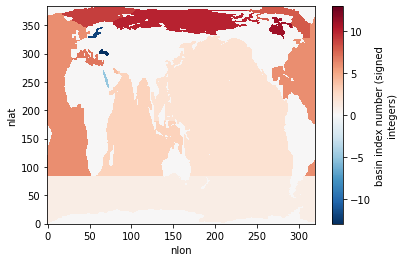

In [48]:
ds_grid_x1.REGION_MASK.plot()

#### CA current

In [49]:
ds_grid_x1.TLAT.isel(nlat=292,nlon=slice(230,245)).values ### Cross section through CA current at 39N

array([39.76472518, 39.69905896, 39.63316061, 39.56705522, 39.50076797,
       39.43432413, 39.36774902, 39.30106807, 39.23430673, 39.16749051,
       39.10064498, 39.0337957 , 38.9669683 , 38.90018837, 38.83348155])

In [50]:
lons_norm_x1.isel(nlat=292,nlon=slice(230,245)).values ### Cross section through CA current at 39N

array([-139.64524521, -138.52001209, -137.39521012, -136.2708353 ,
       -135.14688342, -134.02335007, -132.90023069, -131.77752054,
       -130.65521469, -129.5333081 , -128.41179555, -127.2906717 ,
       -126.16993106, -125.04956804, -123.92957692])

#### SE US shelf

In [51]:
ds_grid_x1.TLAT.isel(nlat=279,nlon=slice(290,310)).values ### Cross section through SE US shelf at 30N

array([30.29841574, 30.27424885, 30.25082555, 30.22815506, 30.20624635,
       30.18510805, 30.16474852, 30.14517581, 30.12639765, 30.10842146,
       30.09125436, 30.07490313, 30.05937425, 30.04467386, 30.03080779,
       30.01778153, 30.00560023, 29.99426873, 29.98379151, 29.97417273])

In [52]:
lons_norm_x1.isel(nlat=279,nlon=slice(291,310)).values ### Cross section through SE US shelf at 30N

array([-71.82306916, -70.70595309, -69.58889397, -68.47188946,
       -67.35493725, -66.23803504, -65.12118056, -64.00437159,
       -62.8876059 , -61.7708813 , -60.65419563, -59.53754675,
       -58.42093253, -57.30435087, -56.18779969, -55.07127692,
       -53.95478054, -52.8383085 , -51.7218588 ])

#### Eq Pacific

In [53]:
ds_grid_x1.TLAT.isel(nlat=194,nlon=slice(223,256)).values ### Cross section through Eq. Pac at 2N


array([2.00600659, 2.00585935, 2.0057112 , 2.0055622 , 2.0054124 ,
       2.00526186, 2.00511064, 2.0049588 , 2.0048064 , 2.00465349,
       2.00450013, 2.00434639, 2.00419232, 2.00403798, 2.00388343,
       2.00372874, 2.00357395, 2.00341914, 2.00326435, 2.00310965,
       2.00295511, 2.00280077, 2.0026467 , 2.00249295, 2.0023396 ,
       2.00218669, 2.00203428, 2.00188244, 2.00173122, 2.00158069,
       2.00143089, 2.00128188, 2.00113373])

In [54]:
lons_norm_x1.isel(nlat=194,nlon=slice(223,256)).values ### Cross section through Eq. Pac at 2N


array([-148.56240426, -147.43740366, -146.3124031 , -145.18740257,
       -144.06240208, -142.93740163, -141.81240121, -140.68740082,
       -139.56240048, -138.43740016, -137.31239989, -136.18739965,
       -135.06239945, -133.93739928, -132.81239915, -131.68739906,
       -130.562399  , -129.43739898, -128.312399  , -127.18739905,
       -126.06239914, -124.93739926, -123.81239942, -122.68739962,
       -121.56239985, -120.43740012, -119.31240043, -118.18740077,
       -117.06240115, -115.93740156, -114.81240201, -113.68740249,
       -112.56240301])

In [55]:
ds_fosi.time[494]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1999, 3, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 1999-03-16 12:00:00

In [56]:
ds_fosi.time[32]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1960, 9, 16, 0, 0, 0, 0), dtype=object)
Coordinates:
    time     object 1960-09-16 00:00:00

### trim datasets

In [73]:
ds_CAcurr_x1 = ds_fosi.isel(time=494,nlat=292,nlon=slice(230,245),z_t=slice(0,17))

In [74]:
ds_SEUS_x1 = ds_fosi.isel(time=494,nlat=279,nlon=slice(290,310),z_t=slice(0,17))

In [75]:
ds_eqPac_x1 = ds_fosi.isel(time=32,nlat=194,nlon=slice(223,257),z_t=slice(0,17))

In [76]:
ds_CAcurr_x1

<xarray.Dataset>
Dimensions:     (d2: 2, nlon: 15, z_t: 17, z_t_150m: 15)
Coordinates:
    TLAT        (nlon) float64 39.76 39.7 39.63 39.57 ... 39.03 38.97 38.9 38.83
    TLONG       (nlon) float64 220.4 221.5 222.6 223.7 ... 233.8 235.0 236.1
    time        object 1999-03-16 12:00:00
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 1.55e+04 1.651e+04
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: d2, nlon
Data variables:
    diatC       (z_t_150m, nlon) float32 ...
    dz          (z_t) float32 1e+03 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1.02e+03
    time_bound  (d2) object 1999-03-01 00:00:00 1999-04-01 00:00:00
    NO3         (z_t, nlon) float32 ...
    HMXL        (nlon) float32 ...
    Fe          (z_t, nlon) float32 ...
    TEMP        (z_t, nlon) float32 ...
    HMXL_DR     (nlon) float32 ...

In [77]:
len(depths)

17

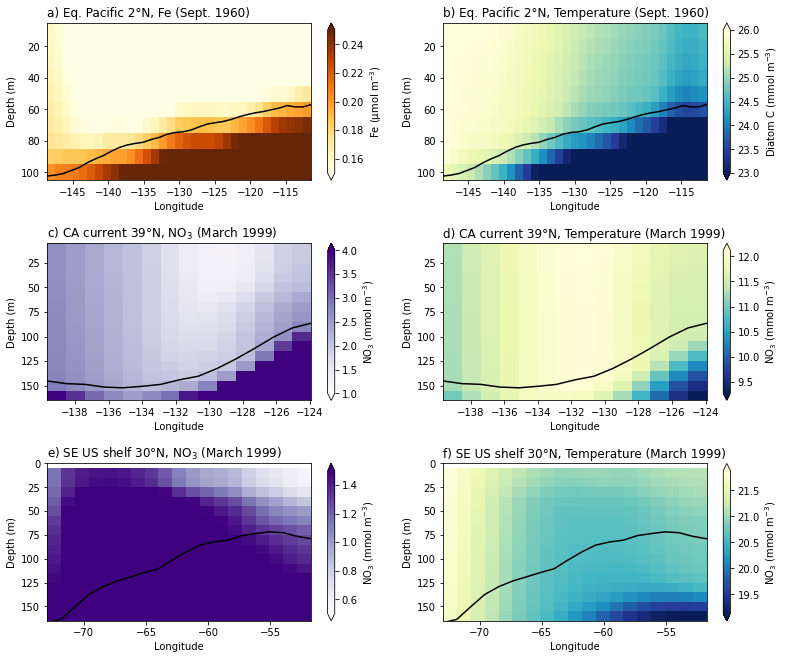

In [85]:
fig = plt.figure(figsize=(13,11))

############# Eq Pac

cmap='YlOrBr'
ax = fig.add_subplot(3,2,1)
ax.set_title('a) Eq. Pacific 2°N, Fe (Sept. 1960)',fontsize=12, loc='left')
#tmp = ds_eqPac.NO3.isel(nlon=slice(2900,3600))
tmp = ds_eqPac_x1.Fe.isel(z_t=slice(0,11))  * 1000 
lon = lons_norm_x1.isel(nlat=194,nlon=slice(223,257))
mld = ds_eqPac_x1.HMXL * 0.01
pc = ax.pcolormesh(lon,depths[0:11],tmp, cmap=cmap, vmin=0.15,vmax=0.25)
#pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=0.15,vmax=0.6)
ml = ax.plot(lon,mld,color='black')
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
#fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');


########### TEMP
cmap='YlGnBu_r'
ax = fig.add_subplot(3,2,2)
ax.set_title('b) Eq. Pacific 2°N, Temperature (Sept. 1960)',fontsize=12, loc='left')
tmp = ds_eqPac_x1.TEMP.isel(z_t=slice(0,11))
lon = lons_norm_x1.isel(nlat=194,nlon=slice(223,257))
pc = ax.pcolormesh(lon,depths[0:11],tmp, cmap=cmap, vmin=23, vmax=26)
plt.gca().invert_yaxis()
mld = ds_eqPac_x1.HMXL * 0.01
ml = ax.plot(lon,mld,color='black')
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Diatom C (mmol m$^{-3}$)',extend='both');

# ############################### Ca CUrrent

### NO3
cmap='Purples'
ax = fig.add_subplot(3,2,3)
ax.set_title('c) CA current 39°N, NO$_3$ (March 1999)',fontsize=12, loc='left')
tmp = ds_CAcurr_x1.NO3
lon = lons_norm_x1.isel(nlat=292,nlon=slice(230,245))
mld = ds_CAcurr_x1.HMXL * 0.01
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=1,vmax=4)
ml = ax.plot(lon,mld,color='black')
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

########### TEMP
cmap='YlGnBu_r'
ax = fig.add_subplot(3,2,4)
ax.set_title('d) CA current 39°N, Temperature (March 1999)',fontsize=12, loc='left')
tmp = ds_CAcurr_x1.TEMP
lon = lons_norm_x1.isel(nlat=292,nlon=slice(230,245))
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap)
plt.gca().invert_yaxis()
mld = ds_CAcurr_x1.HMXL * 0.01
ml = ax.plot(lon,mld,color='black')
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

# ############################### SE US shelf

### NO3
cmap='Purples'
ax = fig.add_subplot(3,2,5)
ax.set_title('e) SE US shelf 30°N, NO$_3$ (March 1999)',fontsize=12, loc='left')
tmp = ds_SEUS_x1.NO3
lon = lons_norm_x1.isel(nlat=279,nlon=slice(290,310))
mld = ds_SEUS_x1.HMXL * 0.01
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap, vmin=0.5,vmax=1.5)
ml = ax.plot(lon,mld,color='black')
ax.set_ylim(0,165)
plt.gca().invert_yaxis()
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

# ########### TEMP
var = 'NO3'
cmap='YlGnBu_r'
ax = fig.add_subplot(3,2,6)
ax.set_title('f) SE US shelf 30°N, Temperature (March 1999)',fontsize=12, loc='left')
tmp = ds_SEUS_x1.TEMP
lon = lons_norm_x1.isel(nlat=279,nlon=slice(290,310))
pc = ax.pcolormesh(lon,depths,tmp, cmap=cmap)
ax.set_ylim(0,165)
plt.gca().invert_yaxis()
mld = ds_SEUS_x1.HMXL * 0.01
ml = ax.plot(lon,mld,color='black')
ax.set(xlabel='Longitude',ylabel='Depth (m)') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

fig.subplots_adjust(hspace=0.4)

fig.savefig('/glade/work/kristenk/figs/Regional_transects_x1.png', bbox_inches='tight', dpi=300, format='png');